In [4]:
## Features Comparison and Identification of Domain Shift

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import requests
import zipfile
import tarfile
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from torch import no_grad
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class LungBiopsyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))

        for label_idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for file in os.listdir(class_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_path, file))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # === Apply CLAHE ===
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        image = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
# ImageNet-style normalization
img_size = 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Paths (update only if your folder names differ)
train_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
external_path = "/kaggle/input/lunghist700forexternaltesting/external_dataset_2/lung_image_sets"

# Load datasets
train_dataset = LungBiopsyDataset(train_path, transform=transform)
external_dataset = LungBiopsyDataset(external_path, transform=transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False)

print("Code block ran successfully")


Code block ran successfully


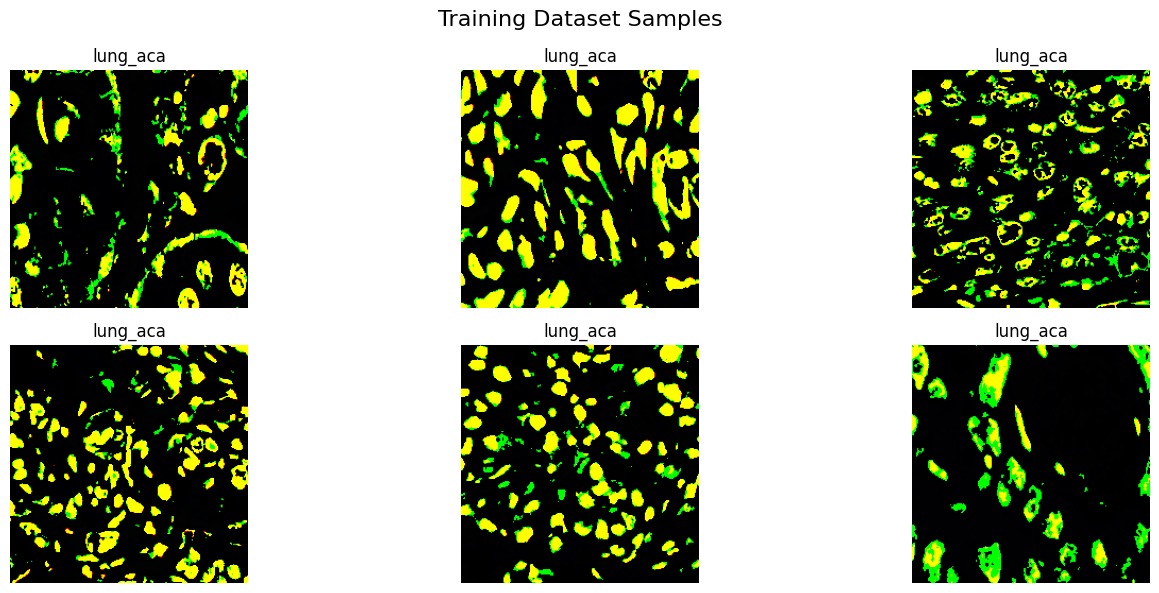

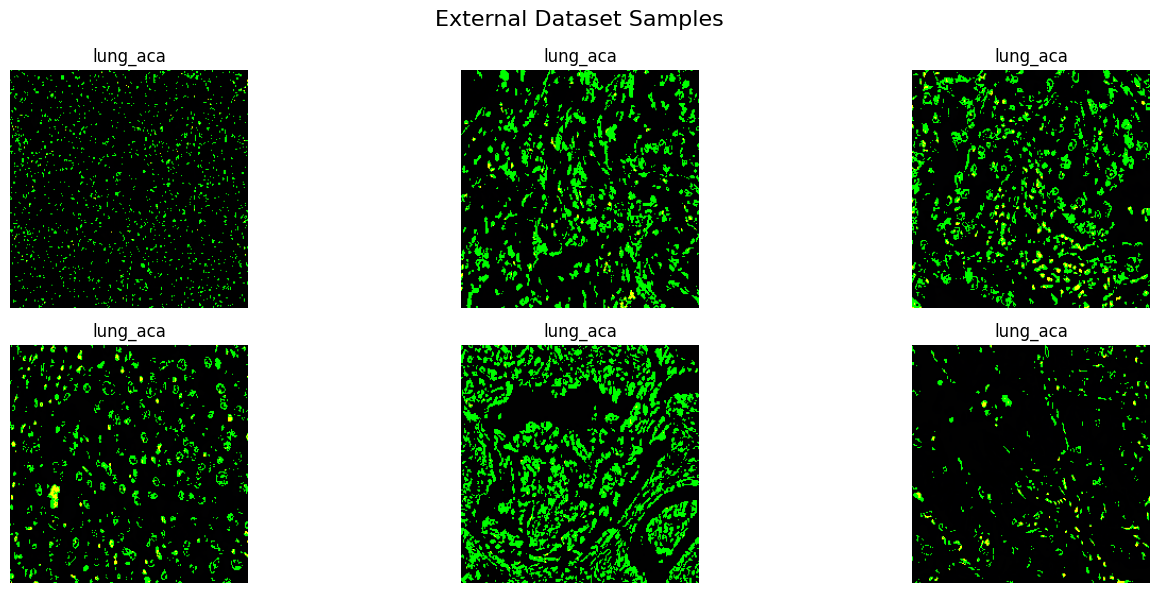

In [11]:
def show_sample_images(dataloader, class_names, title, num_images=6):
    import matplotlib.pyplot as plt

    images_shown = 0
    plt.figure(figsize=(15, 6))
    
    for images, labels in dataloader:
        for i in range(len(images)):
            image = images[i].numpy().transpose(1, 2, 0)
            label = class_names[labels[i].item()]
            
            plt.subplot(2, num_images // 2, images_shown + 1)
            plt.imshow(image.astype('uint8'))
            plt.title(label)
            plt.axis('off')
            
            images_shown += 1
            if images_shown == num_images:
                plt.suptitle(title, fontsize=16)
                plt.tight_layout()
                plt.show()
                return


class_names = train_dataset.class_names

# Show 6 training images
show_sample_images(train_loader, class_names, title="Training Dataset Samples")


# Show 6 external test images
show_sample_images(external_loader, class_names, title="External Dataset Samples")


In [12]:
# Load pretrained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Remove the final fully connected layer (we only need feature extractor)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 242MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [13]:
## Define the Feature Extraction Function

def extract_features(dataloader):
    features = []
    labels = []
    
    with no_grad():
        for images, lbls in tqdm(dataloader):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu().numpy())
            labels.extend(lbls.numpy())
    
    features = np.concatenate(features, axis=0)
    return features, np.array(labels)

print("Defined the feature extraction function")

Defined the feature extraction function


In [14]:
# Extract features for both training and external datasets
train_features, train_labels = extract_features(train_loader)
external_features, external_labels = extract_features(external_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

In [15]:
import pandas as pd

# Convert features to DataFrame
train_df = pd.DataFrame(train_features)
external_df = pd.DataFrame(external_features)

# Optionally add labels for inspection
train_df['Label'] = train_labels
external_df['Label'] = external_labels

# Display first 5 rows
print("Train Features Sample:")
print(train_df.head())

print("\nExternal Features Sample:")
print(external_df.head())


Train Features Sample:
          0         1         2         3         4         5         6  \
0  0.059800  0.359038  0.093027  0.101360  0.086524  0.113473  0.096928   
1  0.029416  0.180458  0.134911  0.091558  0.336817  0.069700  0.060230   
2  0.174739  0.291071  0.247033  0.058233  0.116091  0.372772  0.000000   
3  0.009947  0.287469  0.421787  0.059041  0.505176  0.006630  0.138102   
4  0.179390  0.121292  0.364274  0.347703  0.033267  0.209034  0.002073   

          7         8         9  ...      2039      2040      2041      2042  \
0  0.775735  1.119548  0.831529  ...  0.569363  0.131638  0.179190  0.173604   
1  0.015309  0.436895  0.089361  ...  0.570535  0.000000  0.006399  0.222545   
2  0.021819  0.497142  0.326188  ...  0.309514  0.006797  0.010475  0.011492   
3  0.131476  0.389186  0.360974  ...  0.397357  0.004431  0.022218  0.110077   
4  0.171372  0.261171  0.446940  ...  0.931224  0.003067  0.033729  0.271757   

       2043      2044      2045      2046    

In [16]:
print("Train features shape:", train_features.shape)
print("External features shape:", external_features.shape)

print("\nTrain Features DataFrame Info:")
print(train_df.info())


Train features shape: (15000, 2048)
External features shape: (1075, 2048)

Train Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Columns: 2049 entries, 0 to Label
dtypes: float32(2048), int64(1)
memory usage: 117.3 MB
None


In [49]:
## MMD 

# Gaussian kernel function
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.sum((x - y) ** 2) / (2 * sigma ** 2))

# MMD implementation
def mmd_squared(x, y, sigma=1.0):
    m, n = len(x), len(y)

    # Compute kernel values
    xx = np.zeros((m, m))
    yy = np.zeros((n, n))
    xy = np.zeros((m, n))

    for i in range(m):
        for j in range(m):
            xx[i, j] = gaussian_kernel(x[i], x[j], sigma)

    for i in range(n):
        for j in range(n):
            yy[i, j] = gaussian_kernel(y[i], y[j], sigma)

    for i in range(m):
        for j in range(n):
            xy[i, j] = gaussian_kernel(x[i], y[j], sigma)

    # Compute MMD
    mmd = np.sum(xx) / (m * m) + np.sum(yy) / (n * n) - 2 * np.sum(xy) / (m * n)
    return mmd


In [51]:
# Randomly sample 900 features from each
train_sample = train_features[np.random.choice(len(train_features), 900, replace=False)]
external_sample = external_features[np.random.choice(len(external_features), 900, replace=False)]

mmd_val = mmd_squared(train_sample, external_sample)
print(f"MMD for 900 randomly choosen samples: {mmd_val:.6f}")


MMD for 900 randomly choosen samples: 0.002186


In [55]:
# Randomly sample 2000 features from each
train_sample = train_features[np.random.choice(len(train_features), 2000)]
external_sample = external_features[np.random.choice(len(external_features), 2000)]

mmd_val = mmd_squared(train_sample, external_sample)
print(f"MMD for 2000 randomly choosen samples: {mmd_val:.6f}")


MMD for 2000 randomly choosen samples: 0.001910


Explained variance ratio: [0.3175844  0.08750124]


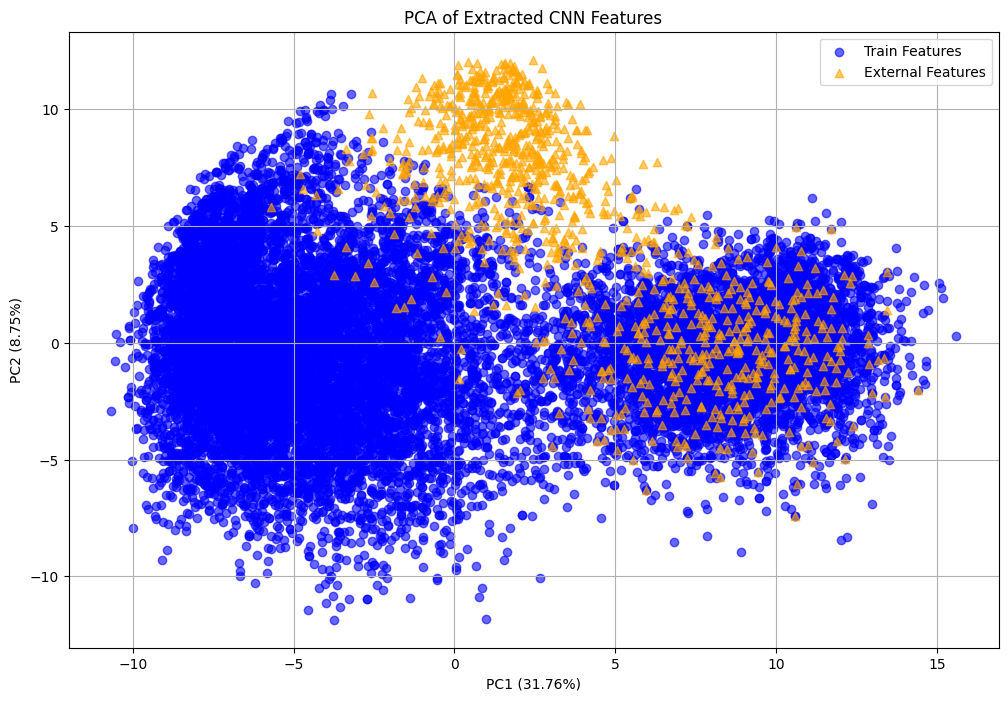

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def apply_pca_and_plot(train_features, external_features, train_labels, external_labels, n_components=2):
    """
    Apply PCA to combined train and external features, and plot them.
    
    Args:
        train_features: Extracted features from the training dataset
        external_features: Extracted features from the external dataset
        train_labels: Corresponding labels (to annotate or color)
        external_labels: Labels for external dataset
        n_components: Number of PCA components to retain
    """
    # Combine both feature sets
    combined_features = np.vstack([train_features, external_features])
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    combined_pca = pca.fit_transform(combined_features)
    
    # Split back
    train_pca = combined_pca[:len(train_features)]
    external_pca = combined_pca[len(train_features):]

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Plot the PCA results
    plt.figure(figsize=(12, 8))
    plt.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label='Train Features', c='blue', marker='o')
    plt.scatter(external_pca[:, 0], external_pca[:, 1], alpha=0.6, label='External Features', c='orange', marker='^')

    plt.title('PCA of Extracted CNN Features')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run PCA and plot
apply_pca_and_plot(train_features, external_features, train_labels, external_labels)


In [22]:
from scipy.stats import wasserstein_distance
import numpy as np

def compute_wasserstein_distances(train_features, external_features, sample_indices=[0, 1, 2]):
    """
    Compute and print Wasserstein distances for selected feature dimensions.

    Args:
        train_features: Numpy array of extracted features from training set
        external_features: Numpy array of extracted features from external set
        sample_indices: List of feature indices to compute Wasserstein distances on
    """
    print("Wasserstein Distances Between Train and External Features:")
    for i in sample_indices:
        if i >= train_features.shape[1] or i >= external_features.shape[1]:
            print(f"Feature index {i} is out of bounds for the feature size.")
            continue
        
        dist = wasserstein_distance(train_features[:, i], external_features[:, i])
        print(f"Feature {i}: {dist:.6f}")

# Example usage (on first 3 feature dimensions)
compute_wasserstein_distances(train_features, external_features, sample_indices=[0, 1, 2])


Wasserstein Distances Between Train and External Features:
Feature 0: 0.003093
Feature 1: 0.066700
Feature 2: 0.017997


Applying t-SNE to feature vectors...


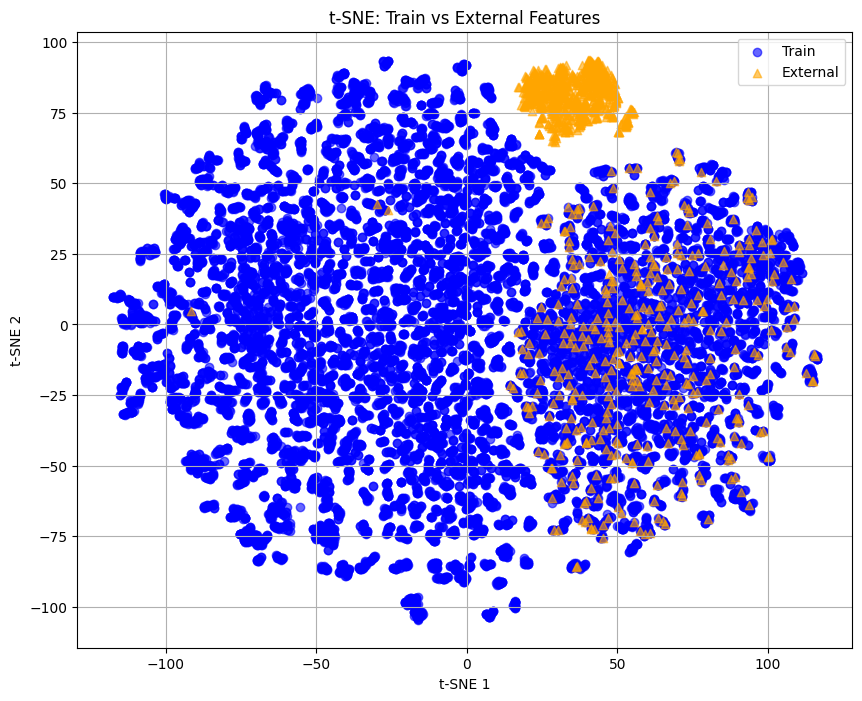

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def apply_tsne(train_features, external_features, perplexity=30, n_iter=1000):
    """
    Apply t-SNE for dimensionality reduction and return transformed features.

    Args:
        train_features: Features from the training dataset
        external_features: Features from the external dataset
        perplexity: t-SNE perplexity parameter
        n_iter: Number of iterations

    Returns:
        train_tsne, external_tsne: 2D transformed features
    """
    combined = np.vstack([train_features, external_features])

    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    combined_tsne = tsne.fit_transform(combined)

    train_tsne = combined_tsne[:len(train_features)]
    external_tsne = combined_tsne[len(train_features):]

    return train_tsne, external_tsne

def plot_tsne(train_tsne, external_tsne, train_label='Train', external_label='External'):
    """
    Plot 2D t-SNE visualization for train and external features.

    Args:
        train_tsne: 2D t-SNE of training features
        external_tsne: 2D t-SNE of external features
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(train_tsne[:, 0], train_tsne[:, 1], marker='o', alpha=0.6, label=train_label, c='blue')
    plt.scatter(external_tsne[:, 0], external_tsne[:, 1], marker='^', alpha=0.6, label=external_label, c='orange')
    plt.title('t-SNE: Train vs External Features')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---- Run t-SNE ----
try:
    print("Applying t-SNE to feature vectors...")
    train_tsne, external_tsne = apply_tsne(train_features, external_features)
    plot_tsne(train_tsne, external_tsne)
except Exception as e:
    print(f"Error in t-SNE visualization: {e}")


In [28]:
## extract features names

cnn_feature_names = [f"Feature_{i}" for i in range(train_features.shape[1])]
print(cnn_feature_names)

['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature_66', 'Feature_67', 'Feature_68', 'Feature_69', 'Feature_70', 'Feature_71', '

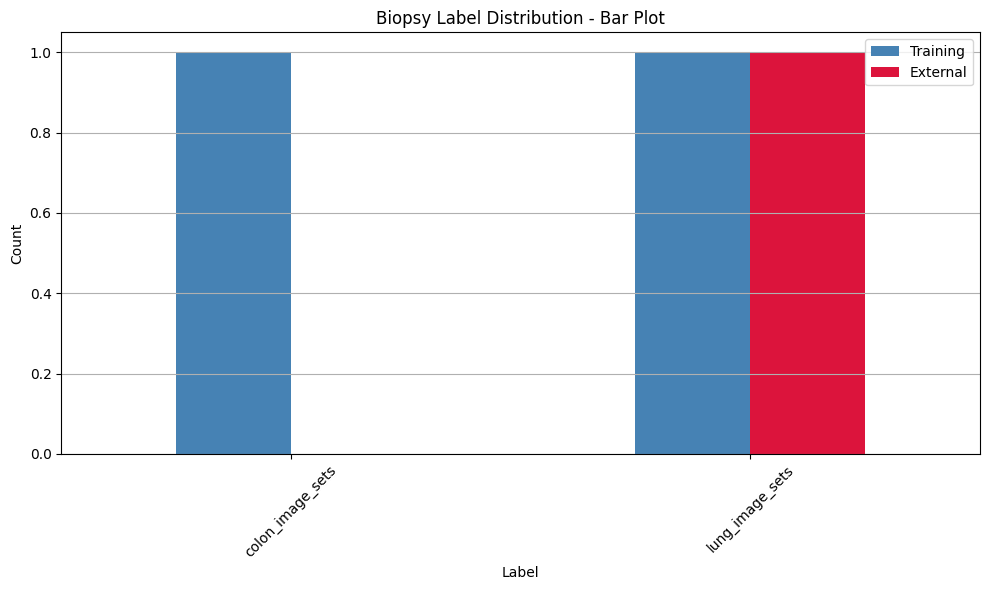

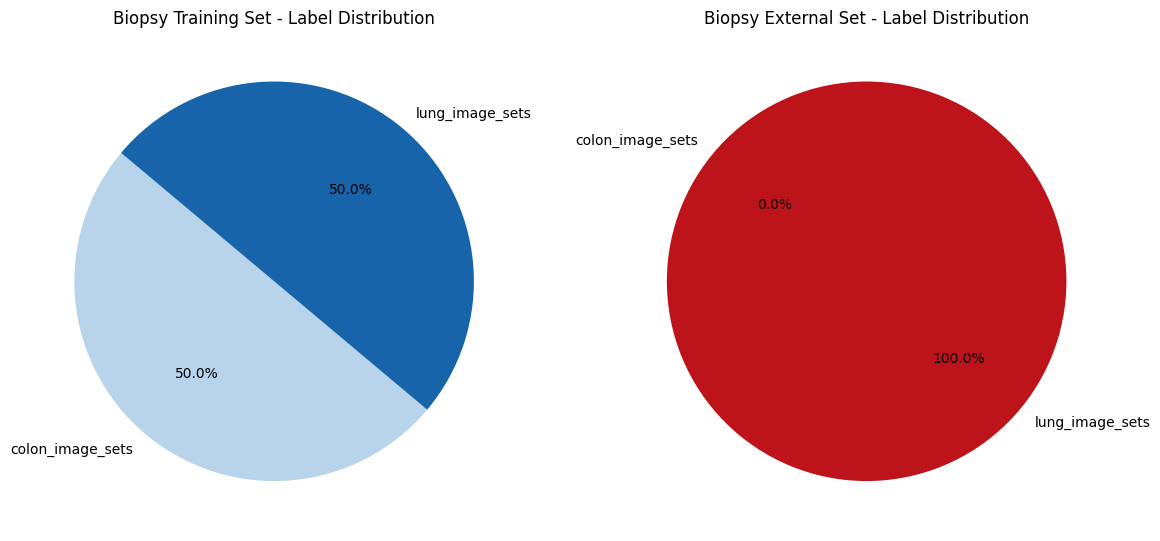

In [37]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def plot_label_distribution_comparison(train_root_dir, external_root_dir, title_prefix=""):
    """
    Count and compare label distributions for training and external datasets based on folder names.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        title_prefix (str): Prefix for the plot titles (e.g., "Biopsy Dataset").
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Convert to DataFrame for easy handling
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))
    df = pd.DataFrame({
        'Label': all_labels,
        'Training': [train_counter.get(label, 0) for label in all_labels],
        'External': [external_counter.get(label, 0) for label in all_labels]
    })

    # Step 4: Plotting side-by-side bar chart
    df_plot = df.set_index('Label')
    ax = df_plot.plot(kind='bar', figsize=(10, 6), color=['steelblue', 'crimson'])
    plt.title(f"{title_prefix} Label Distribution - Bar Plot")
    plt.ylabel("Count")
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Step 5: Pie Charts
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    blues = plt.cm.Blues(np.linspace(0.3, 0.8, len(df)))
    reds = plt.cm.Reds(np.linspace(0.3, 0.8, len(df)))

    axs[0].pie(df['Training'], labels=df['Label'], autopct='%1.1f%%', startangle=140, colors=blues)
    axs[0].set_title(f"{title_prefix} Training Set - Label Distribution")

    axs[1].pie(df['External'], labels=df['Label'], autopct='%1.1f%%', startangle=140, colors=reds)
    axs[1].set_title(f"{title_prefix} External Set - Label Distribution")

    plt.tight_layout()
    plt.show()

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/lunghist700forexternaltesting/external_dataset_2/'  # Replace with the path to your external dataset

plot_label_distribution_comparison(train_root_dir, external_root_dir, title_prefix="Biopsy")


In [40]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import os
from collections import Counter

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def chi_square_test_for_label_distribution(train_root_dir, external_root_dir):
    """
    Conducts a Chi-Square test to compare label distributions between training and external datasets.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        
    Returns:
        chi2_stat: Chi-Square statistic.
        p_value: p-value from the Chi-Square test.
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Ensure all possible labels are accounted for
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))
    
    # Step 4: Create observed frequency table
    observed = np.array([
        [train_counter.get(label, 0) for label in all_labels],
        [external_counter.get(label, 0) for label in all_labels]
    ])

    # Step 5: Conduct Chi-Square test
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(observed)

    # Step 6: Interpretation of the result
    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("There is a significant difference in label distributions (Prior Shift).")
    else:
        print("There is no significant difference in label distributions (No Prior Shift).")
    
    return chi2_stat, p_value

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/lunghist700forexternaltesting/external_dataset_2'  # Replace with the path to your external dataset

# Run the Chi-Square test
chi2_stat, p_value = chi_square_test_for_label_distribution(train_root_dir, external_root_dir)


Chi-Square Statistic: 0.0
P-value: 1.0
There is no significant difference in label distributions (No Prior Shift).


In [41]:

from collections import Counter

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def kl_divergence(train_root_dir, external_root_dir):
    """
    Calculates the Kullback-Leibler divergence between the label distributions 
    of the training and external datasets.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        
    Returns:
        kl_divergence: KL Divergence score.
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Ensure all possible labels are accounted for
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))

    # Step 4: Convert counts to probabilities
    total_train_samples = len(train_labels)
    total_external_samples = len(external_labels)

    train_probabilities = {label: train_counter.get(label, 0) / total_train_samples for label in all_labels}
    external_probabilities = {label: external_counter.get(label, 0) / total_external_samples for label in all_labels}

    # Step 5: Calculate KL Divergence
    kl_div = 0.0
    for label in all_labels:
        p = train_probabilities[label]
        q = external_probabilities[label]
        if p > 0 and q > 0:
            kl_div += p * np.log(p / q)  # KL divergence formula

    return kl_div

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/lunghist700forexternaltesting/external_dataset_2'  # Replace with the path to your external dataset

# Calculate KL Divergence
kl_div = kl_divergence(train_root_dir, external_root_dir)

# Print the result
print(f"KL Divergence: {kl_div}")


KL Divergence: -0.34657359027997264


In [43]:

from collections import Counter

def get_labels_from_directory(root_dir):
    """
    Extract labels from directory structure.
    Assumes that subdirectories' names are the labels.
    
    Args:
        root_dir (str): Path to the root directory containing subdirectories.
        
    Returns:
        list: List of labels based on subdirectory names.
    """
    labels = []
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            labels.append(subdir)  # Using folder name as label
    return labels

def kl_divergence(train_root_dir, external_root_dir):
    """
    Calculates the Kullback-Leibler divergence between the label distributions 
    of the training and external datasets.
    
    Args:
        train_root_dir (str): Root directory of the training dataset.
        external_root_dir (str): Root directory of the external dataset.
        
    Returns:
        kl_divergence: KL Divergence score.
    """
    # Step 1: Get labels from directories
    train_labels = get_labels_from_directory(train_root_dir)
    external_labels = get_labels_from_directory(external_root_dir)

    # Step 2: Count labels using Counter
    train_counter = Counter(train_labels)
    external_counter = Counter(external_labels)

    # Step 3: Ensure all possible labels are accounted for
    all_labels = sorted(set(train_counter.keys()).union(set(external_counter.keys())))

    # Step 4: Convert counts to probabilities
    total_train_samples = len(train_labels)
    total_external_samples = len(external_labels)

    train_probabilities = {label: train_counter.get(label, 0) / total_train_samples for label in all_labels}
    external_probabilities = {label: external_counter.get(label, 0) / total_external_samples for label in all_labels}

    # Step 5: Calculate KL Divergence
    kl_div = 0.0
    for label in all_labels:
        p = train_probabilities[label]
        q = external_probabilities[label]
        if p > 0 and q > 0:
            kl_div += p * np.log(p / q)  # KL divergence formula

    return kl_div

# Example Usage
train_root_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'  # Replace with the path to your training dataset
external_root_dir = '/kaggle/input/lunghist700forexternaltesting/external_dataset_2/lung_image_sets'  # Replace with the path to your external dataset

# Calculate KL Divergence
kl_div = kl_divergence(train_root_dir, external_root_dir)

# Print the result
print(f"KL Divergence: {kl_div}")


KL Divergence: 0.0
